In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import os, sys
import os.path as osp
from utils import *
import matplotlib
import scipy
from scipy import io

In [9]:
def gelsight_dm2pc(heightmap, mpp=0.0634/1000.):
    """
    Convert heightmap / depth map (unit: pixel) to point cloud (unit: m)
    """
    imgh, imgw = heightmap.shape[:2]
    x = np.arange(imgw) * mpp
    y = np.arange(imgh) * mpp
    X, Y = np.meshgrid(x, y)
    points = np.zeros([imgw * imgh, 3])
    points[:, 0] = np.ndarray.flatten(X)
    points[:, 1] = np.ndarray.flatten(Y)
    points[:, 2] = np.ndarray.flatten(heightmap) * mpp
    # flip z so that positive z is pointing outwards the gel pad
    points[:, 2] = -points[:, 2]
    return points

In [10]:
def obtain_gelsight_pose_gelsightsim(parent_dir, obj_name, sample_idx, verbose=False):
        """
        Given the obj_name and sample_idx of heightmap, obtain the sampled gelsight pose.
        The gelsight pose is used to transform the point cloud from gelsight frame to world frame.

        Ref: gelsightSimPybullet.py
        """
        data_path = osp.join(parent_dir,'data', obj_name, obj_name+'_60sampled_python.mat') 
        data_dict = scipy.io.loadmat(data_path)
        sample_points = data_dict['samplePoints'] # N+1 * 3
        sample_normals = data_dict['sampleNormals'] # N+1 * 3
        cur_point = sample_points[sample_idx, :]
        cur_normal = -1 * sample_normals[sample_idx, :]
        z_axis = np.array([0,0,1])
        if verbose: print(f"cur_point: {cur_point}, cur_normal: {cur_normal}, z_axis: {z_axis}")

        T_wp = np.zeros((4,4)) # transform from point coord to world coord
        T_wp[3,3] = 1
        T_wp[0:3,3] = cur_point # t

        if (z_axis==cur_normal).all():
            T_wp[0:3,0:3] = np.indentity(3)
        else:
            # generate rotation for sensor
            v = np.cross(z_axis,cur_normal)
            s = np.linalg.norm(v)
            c = np.dot(z_axis,cur_normal)
            Rot = np.identity(3) + skewMat(v) + np.linalg.matrix_power(skewMat(v),2) * (1-c)/(s**2) # rodrigues
            T_wp[0:3,0:3] = Rot

        return T_wp

shape_mapping_root_path: /home/ruihan/Documents/16741_proj/Shape_Mapping_Tactile-main
sample_heightmap.shape: (240, 320), range min max: (0.0, 18.783133025233987)
sample_pc.shape: (76800, 3), range min max: (-0.0011908506337998347, -0.0)


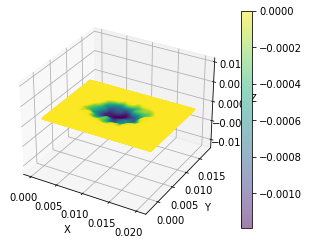

check gelsight_pose: (4, 4)


'# https://github.com/mikedh/trimesh\n\no geometry_0\nv -0.01366961 -0.00456926 0.00429743\nv -0.01360624 -0.00456882 0.00429915\nv -0.01354286 -0.00456838 0.00430088\nv -0.01347949 -0.00456794 0.00430260\nv -0.01341612 -0.00456750 0.00430432\nv -0.01335274 -0.00456707 0.00430605\nv -0.01328937 -0.00456663 0.00430777\nv -0.01322600 -0.00456619 0.00430949\nv -0.01316262 -0.00456575 0.00431122\nv -0.01309925 -0.00456531 0.00431294\nv -0.01303588 -0.00456488 0.00431466\nv -0.01297250 -0.00456444 0.00431638\nv -0.01290913 -0.00456400 0.00431811\nv -0.01284576 -0.00456356 0.00431983\nv -0.01278238 -0.00456312 0.00432155\nv -0.01271901 -0.00456268 0.00432328\nv -0.01265564 -0.00456225 0.00432500\nv -0.01259226 -0.00456181 0.00432672\nv -0.01252889 -0.00456137 0.00432845\nv -0.01246552 -0.00456093 0.00433017\nv -0.01240214 -0.00456049 0.00433189\nv -0.01233877 -0.00456005 0.00433362\nv -0.01227540 -0.00455962 0.00433534\nv -0.01221202 -0.00455918 0.00433706\nv -0.01214865 -0.00455874 0.004338

In [11]:
obj_name = "strawberry"

shape_mapping_root_path = osp.normpath(osp.join(osp.abspath(''), '..', '..', '..'))
print(f"shape_mapping_root_path: {shape_mapping_root_path}")

heightmap_dir = osp.join(shape_mapping_root_path, "processed_data", obj_name, "gt_height_map")
gelsight_sample_idx = 3
sample_heightmap_path = osp.join(heightmap_dir, f"{gelsight_sample_idx}.npy")
sample_heightmap = np.load(sample_heightmap_path)
print(f"sample_heightmap.shape: {sample_heightmap.shape}, range min max: {np.min(sample_heightmap), np.max(sample_heightmap)}")

# convert height map to point cloud
sample_pc = gelsight_dm2pc(sample_heightmap)
print(f"sample_pc.shape: {sample_pc.shape}, range min max: {np.min(sample_pc[:, -1]), np.max(sample_pc[:, -1])}")

# visualize point cloud in 3D   
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample_pc[:, 0], sample_pc[:, 1], sample_pc[:, 2], c=sample_pc[:, 2], cmap='viridis', s=1, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)
plt.colorbar(ax.scatter(sample_pc[:, 0], sample_pc[:, 1], sample_pc[:, 2], c=sample_pc[:, 2], cmap='viridis', s=1, alpha=0.5))
plt.show()



# map the color map based on z value
custom_cm = matplotlib.colormaps['viridis']
normalized_z = (sample_pc[:, 2] - sample_pc[:, 2].min())/ (sample_pc[:, 2].max()- sample_pc[:, 2].min())
pc_colors = custom_cm(normalized_z)

pc_colors = np.zeros((sample_pc.shape[0], 4))
pc_colors[:, 3] = 1
pc_colors[:, 0] = 10 # pc[:, 0] / pc[:, 0].max() # R
pc_colors[:, 1] = 200 #  pc[:, 1] / pc[:, 1].max() # G
pc_colors[:, 2] = ((sample_pc[:, 2] - sample_pc[:, 2].min())/ (sample_pc[:, 2].max()- sample_pc[:, 2].min()) * 255).astype(np.int16) # B

# transform the point cloud so that the origin is at the center of the gel pad
sample_pc[:, 0] -= sample_pc[:, 0].mean()
sample_pc[:, 1] -= sample_pc[:, 1].mean()

# obtain the gelsight pose
gelsight_pose = obtain_gelsight_pose_gelsightsim(shape_mapping_root_path, obj_name, gelsight_sample_idx, verbose=False)
print(f"check gelsight_pose: {gelsight_pose.shape}")
pc_gelsight_data = trimesh.points.PointCloud(sample_pc, colors=pc_colors)
pc_gelsight_data.apply_transform(gelsight_pose)


# save the point cloud as a trimesh scene
pc_scene = trimesh.Scene(pc_gelsight_data)
# pc_scene.show()
pc_scene.export(osp.join(heightmap_dir, f"{gelsight_sample_idx}.obj"))

In [12]:
# Visualize the height map point cloud with textured object mesh, in order to verify the consistency of the coordiante system before sampling camera images
# load object mesh

# manually copy the google_512k folder from model/xxx_obj_name to processed_data/obj_name
obj_mesh_path = osp.join(shape_mapping_root_path, "processed_data", obj_name, "google_512k", "textured.obj")
obj_mesh = trimesh.load(obj_mesh_path)
print(f"obj_mesh.vertices.shape: {obj_mesh.vertices.shape}, obj_mesh.faces.shape: {obj_mesh.faces.shape}")



obj_mesh.vertices.shape: (263112, 3), obj_mesh.faces.shape: (524288, 3)
